<a href="https://colab.research.google.com/github/arjay55/CS284_PA3/blob/main/train_valid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
%matplotlib inline

In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [18]:
path = "./drive/MyDrive/CS284/PA3/DATA"

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [19]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root=path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



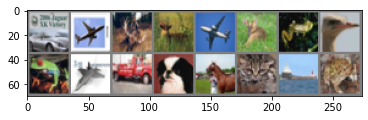

  car plane  deer  deer plane  deer  frog  bird  frog plane truck   dog horse   cat  ship  frog


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [21]:

class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()

        #accessible attributes
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.batch = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(self.batch(x))

        return x


In [22]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1, ch3):
        super().__init__()

        #accessible attributes
        self.ch1 = ch1
        self.ch3 = ch3

        self.convch1 = Conv(in_channels, ch1, 1, 1)
        self.convch3 = Conv(in_channels, ch3, 3, 1, 1)
        
    def forward(self, x):
        ch1features = self.convch1(x)
        ch3features = self.convch3(x)
        x = torch.cat((ch1features,ch3features),1)
        return x


In [23]:
class Downsample(nn.Module):
    def __init__(self, in_channels, ch3):
        super().__init__()

        #accessible attributes
        self.ch3 = ch3

        self.convch3 = Conv(in_channels, ch3, 3, 2)
        self.maxpool = nn.MaxPool2d(3, 2)
        
    def forward(self, x):
        x = self.convch3(x)
        x = self.maxpool(x)
        return x


In [24]:
class MiniGoogleNet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv_in = Conv(in_channels, 96, 3, 1)

        self.inception1a = Inception(96, 32, 32)
        self.inception1b = Inception(64, 32, 48)
        self.downsample1 = Downsample(32+48, 80)

        #cut things short to try it out
        self.meanpool = nn.AdaptiveAvgPool2d(1)
        self.fcout = nn.Linear(80, 10) # for the sake of continuity.

    def forward(self, x):
        x = self.conv_in(x)

        x = self.inception1a(x)
        x = self.inception1b(x)
        x = self.downsample1(x)

        x = self.meanpool(x)
        x = torch.flatten(x, 1)
        x = self.fcout(x)
        return x


3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [25]:
net = MiniGoogleNet(3)

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

cuda:0


MiniGoogleNet(
  (conv_in): Conv(
    (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
    (batch): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (inception1a): Inception(
    (convch1): Conv(
      (conv): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1))
      (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convch3): Conv(
      (conv): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (inception1b): Inception(
    (convch1): Conv(
      (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convch3): Conv(
      (conv): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, trac

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [28]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            PATH = './drive/MyDrive/cifar_net.pth'
            torch.save(net.state_dict(), PATH)

print('Finished Training')

[1,  2000] loss: 1.635
[2,  2000] loss: 1.252
[3,  2000] loss: 1.105
[4,  2000] loss: 0.988
[5,  2000] loss: 0.917
[6,  2000] loss: 0.852
[7,  2000] loss: 0.793
[8,  2000] loss: 0.742
[9,  2000] loss: 0.710
[10,  2000] loss: 0.667
Finished Training


Let's quickly save our trained model:



In [29]:
PATH = './drive/MyDrive/cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [33]:
pwd

'/content'

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



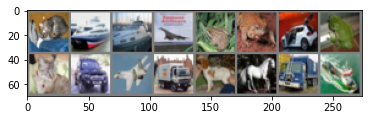

GroundTruth:    cat  ship  ship plane


In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [35]:
net = MiniGoogleNet(3)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [36]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [37]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [38]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 72 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [39]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data    
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 68.8 %
Accuracy for class car   is: 73.4 %
Accuracy for class bird  is: 64.5 %
Accuracy for class cat   is: 50.9 %
Accuracy for class deer  is: 72.5 %
Accuracy for class dog   is: 81.0 %
Accuracy for class frog  is: 77.0 %
Accuracy for class horse is: 63.3 %
Accuracy for class ship  is: 77.4 %
Accuracy for class truck is: 91.8 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


